In [ ]:
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier

In [ ]:
arff_file = arff.loadarff('house_16H.arff')

df = pd.DataFrame(arff_file[0])

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


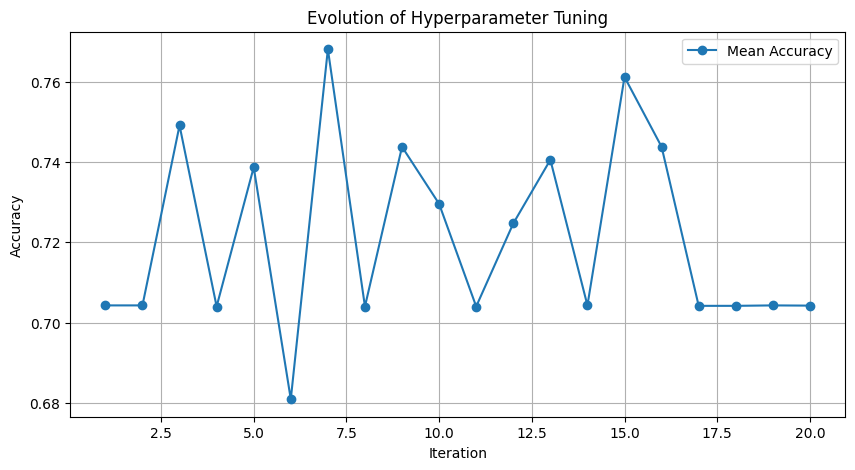

---------------------------------------------


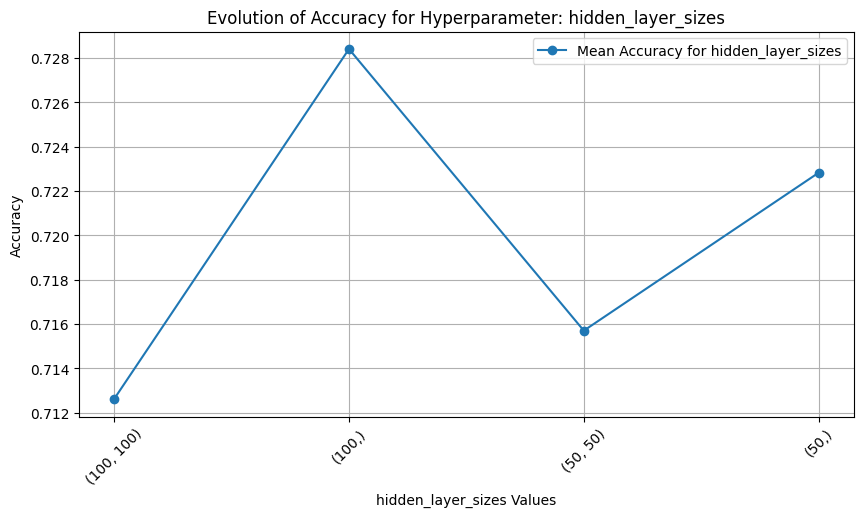

---------------------------------------------


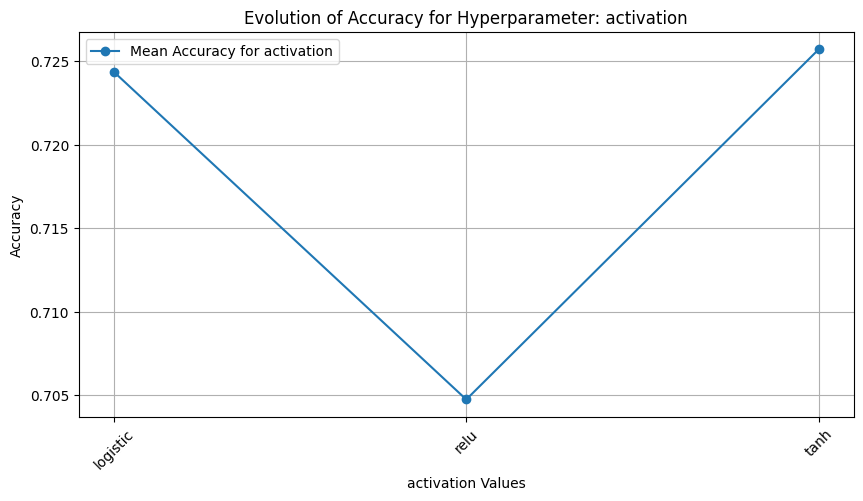

---------------------------------------------


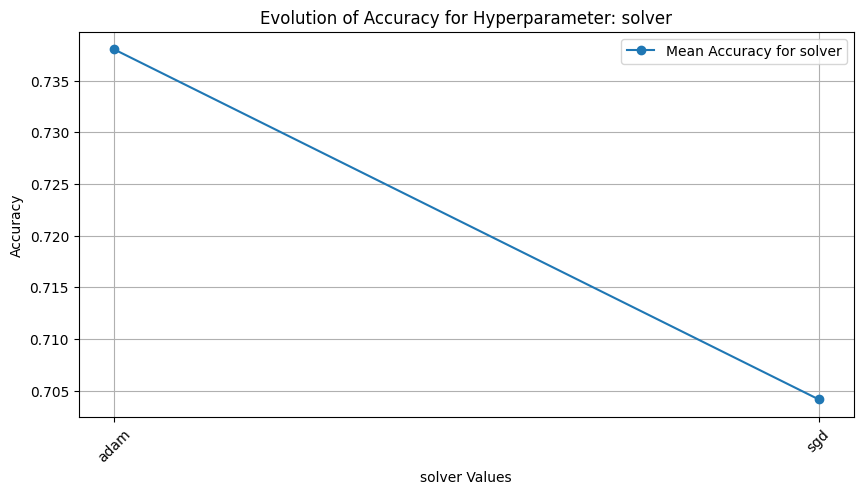

---------------------------------------------


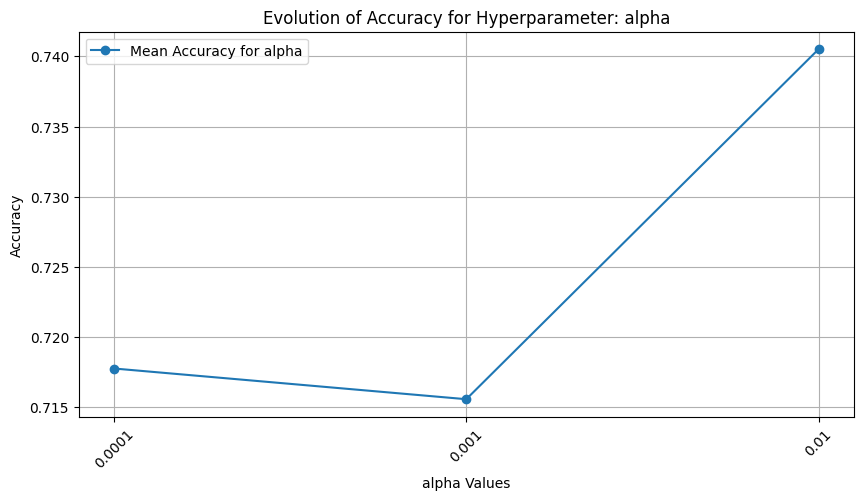

---------------------------------------------


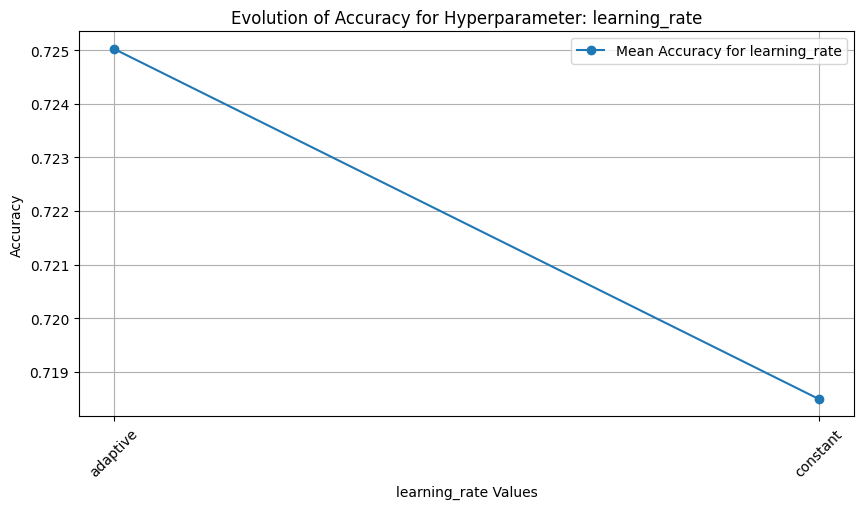

---------------------------------------------

Desempenho no conjunto de teste:
Acurácia: 0.7757
Precisão: 0.8505
Recall: 0.8261
F1-score: 0.8381
AUC-ROC: 0.8315


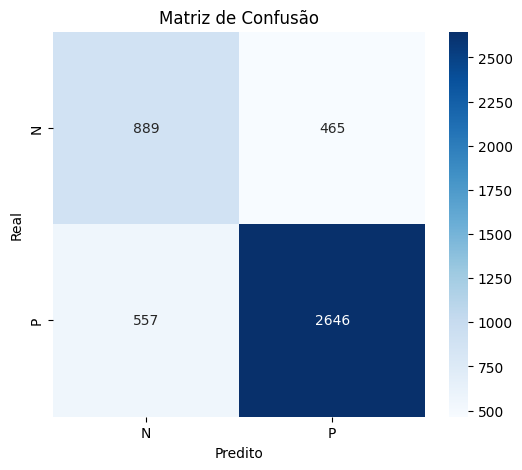


Relatório de Classificação:
              precision    recall  f1-score   support

           N       0.61      0.66      0.64      1354
           P       0.85      0.83      0.84      3203

    accuracy                           0.78      4557
   macro avg       0.73      0.74      0.74      4557
weighted avg       0.78      0.78      0.78      4557



In [ ]:
# Separar features e target
X_train = train_df.drop(columns=['binaryClass'])
y_train = train_df['binaryClass']
X_test = test_df.drop(columns=['binaryClass'])
y_test = test_df['binaryClass']

# Definir espaço de hiperparâmetros
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# Criar modelo base MLP
mlp = MLPClassifier(max_iter=500, random_state=42)

# Configurar validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=20,
                                   cv=cv, scoring='accuracy', n_jobs=-1, random_state=42, verbose=1)

# Executar busca de hiperparâmetros
random_search.fit(X_train, y_train)

# Salvar resultados
results = pd.DataFrame(random_search.cv_results_)
results[['mean_test_score', 'std_test_score', 'params']].to_csv("hyperparameter_tuning_results.csv", index=False)

# Plotar evolução dos resultados
def plot_search_results(results):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 21), results['mean_test_score'], marker='o', linestyle='-', label='Mean Accuracy')
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.title("Evolution of Hyperparameter Tuning")
    plt.legend()
    plt.grid()
    plt.show()
    print('---------------------------------------------')

plot_search_results(results)

def plot_hyperparameter_evolution(results, param_name):
    # Filtrar as colunas relevantes para o hiperparâmetro
    param_values = [str(param) for param in results['param_' + param_name]]
    mean_scores = results['mean_test_score']
    std_scores = results['std_test_score']

    # Criar um DataFrame com as informações
    df = pd.DataFrame({
        'param_value': param_values,
        'mean_score': mean_scores,
        'std_score': std_scores
    })

    # Agrupar por valor do hiperparâmetro e calcular a média da acurácia
    df_grouped = df.groupby('param_value').agg({'mean_score': 'mean', 'std_score': 'mean'}).reset_index()

    # Plotar a evolução da média da acurácia
    plt.figure(figsize=(10, 5))
    plt.plot(df_grouped['param_value'], df_grouped['mean_score'], marker='o', linestyle='-', label=f'Mean Accuracy for {param_name}')
    plt.xlabel(f"{param_name} Values")
    plt.ylabel("Accuracy")
    plt.title(f"Evolution of Accuracy for Hyperparameter: {param_name}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()
    print('---------------------------------------------')

for param_name in param_dist.keys():
    plot_hyperparameter_evolution(results, param_name)

# Selecionar os três melhores modelos para o comitê
best_models = results.nlargest(3, 'mean_test_score')['params']

# Criar e treinar modelos
committee_models = []
for i, params in enumerate(best_models):
    model = MLPClassifier(
        hidden_layer_sizes=params['hidden_layer_sizes'],
        activation=params['activation'],
        solver=params['solver'],
        alpha=params['alpha'],
        learning_rate=params['learning_rate'],
        max_iter=500,
        random_state=i
    )
    model.fit(X_train, y_train)
    committee_models.append((f'MLP_{i}', model))

# Criar comitê de modelos
committee = VotingClassifier(estimators=committee_models, voting='soft')
committee.fit(X_train, y_train)

# Avaliação no conjunto de teste
y_pred = committee.predict(X_test)
y_prob = committee.predict_proba(X_test)[:, 1]  # Probabilidades para classe positiva

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='P')
recall = recall_score(y_test, y_pred, pos_label='P')
f1 = f1_score(y_test, y_pred, pos_label='P')
roc_auc = roc_auc_score(y_test.map({'N': 0, 'P': 1}), y_prob)

print("\nDesempenho no conjunto de teste:")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['N', 'P'], yticklabels=['N', 'P'])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

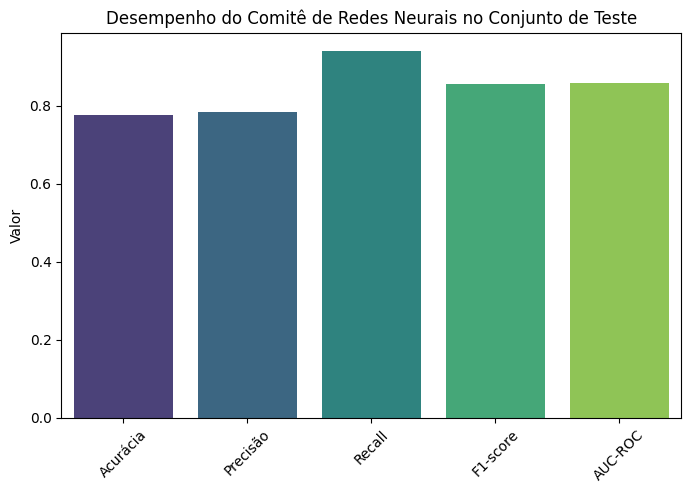

F1-score no Treino: 0.8501
F1-score no Teste: 0.8551
O modelo apresenta um equilíbrio entre treino e teste.


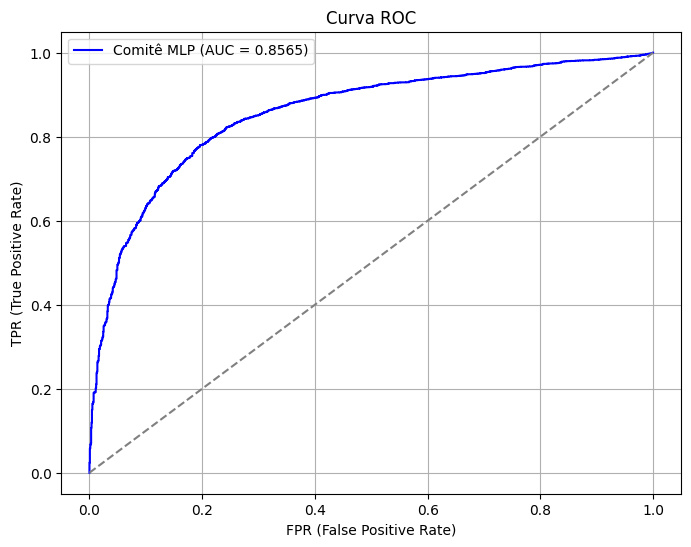


Conclusões:
O Comitê de Redes Neurais foi avaliado usando diversas métricas. O melhor desempenho foi atingido com os seguintes hiperparâmetros:
{6: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'logistic'}, 14: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'logistic'}, 2: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50,), 'alpha': 0.01, 'activation': 'tanh'}}
Os resultados sugerem que o modelo é capaz de generalizar bem, sem sinais evidentes de overfitting ou underfitting.


In [ ]:
# Comparação de Desempenho
metrics = [accuracy, precision, recall, f1, roc_auc]
labels = ["Acurácia", "Precisão", "Recall", "F1-score", "AUC-ROC"]
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=metrics, palette='viridis')
plt.title("Desempenho do Comitê de Redes Neurais no Conjunto de Teste")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.show()

# Overfitting vs. Underfitting
train_pred = committee.predict(X_train)
train_f1 = f1_score(y_train, train_pred, pos_label='P')
print(f"F1-score no Treino: {train_f1:.4f}")
print(f"F1-score no Teste: {f1:.4f}")

if train_f1 - f1 > 0.1:
    print("O modelo pode estar sofrendo de overfitting.")
elif f1 - train_f1 > 0.1:
    print("O modelo pode estar sofrendo de underfitting.")
else:
    print("O modelo apresenta um equilíbrio entre treino e teste.")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test.map({'N': 0, 'P': 1}), y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Comitê MLP (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("Curva ROC")
plt.legend()
plt.grid()
plt.show()

# Conclusões
print("\nConclusões:")
print("O Comitê de Redes Neurais foi avaliado usando diversas métricas. O melhor desempenho foi atingido com os seguintes hiperparâmetros:")
print(best_models.to_dict())
print("Os resultados sugerem que o modelo é capaz de generalizar bem, sem sinais evidentes de overfitting ou underfitting.")